In [1]:
!pip3 install scipy
import warnings
warnings.filterwarnings("ignore")

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import scipy.io
mat = scipy.io.loadmat('../train_32x32.mat')

In [3]:
import cv2

def convert_dataset_to_grayscale(dataset):
    gray_dataset = []
    for image in dataset:
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        gray_dataset.append(gray_image)
    return np.array(gray_dataset)

In [4]:
import numpy as np

X = mat['X']
y = mat['y']

X = np.transpose(X, (3, 0, 1, 2))
X_gray = convert_dataset_to_grayscale(X)/255
X = X_gray
y = y-1
X.shape,y.shape


((73257, 32, 32), (73257, 1))

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=1)


X_train, X_val, y_train, y_val = train_test_split( 
    X_train, y_train, test_size=int((200/9)*0.9), random_state=1) # (200/9)* 0.9 = 0.2

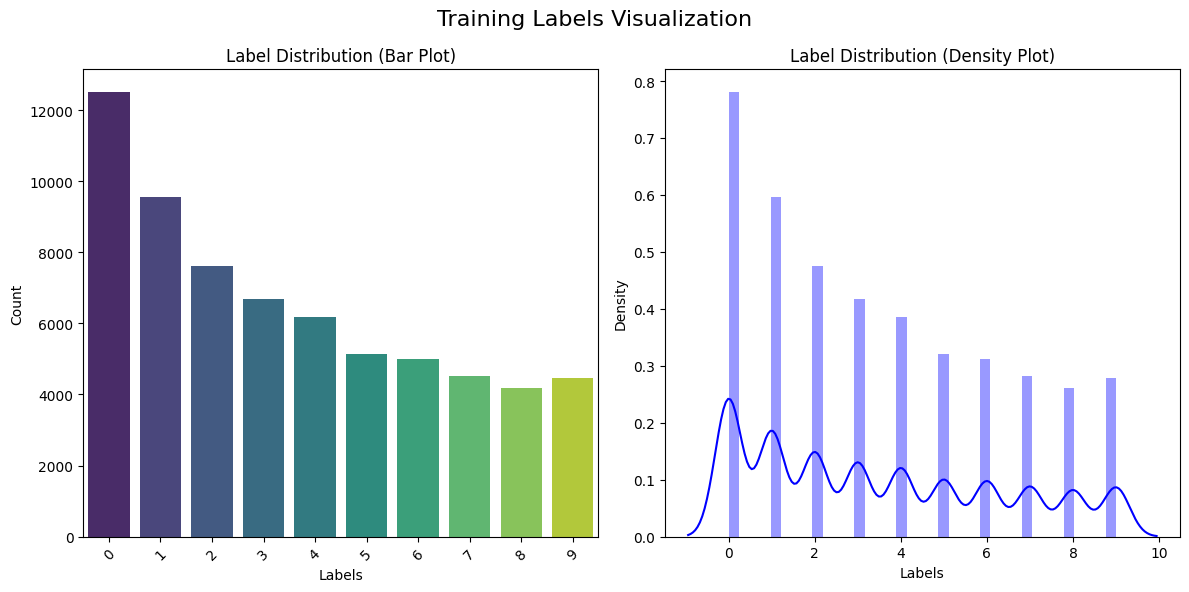

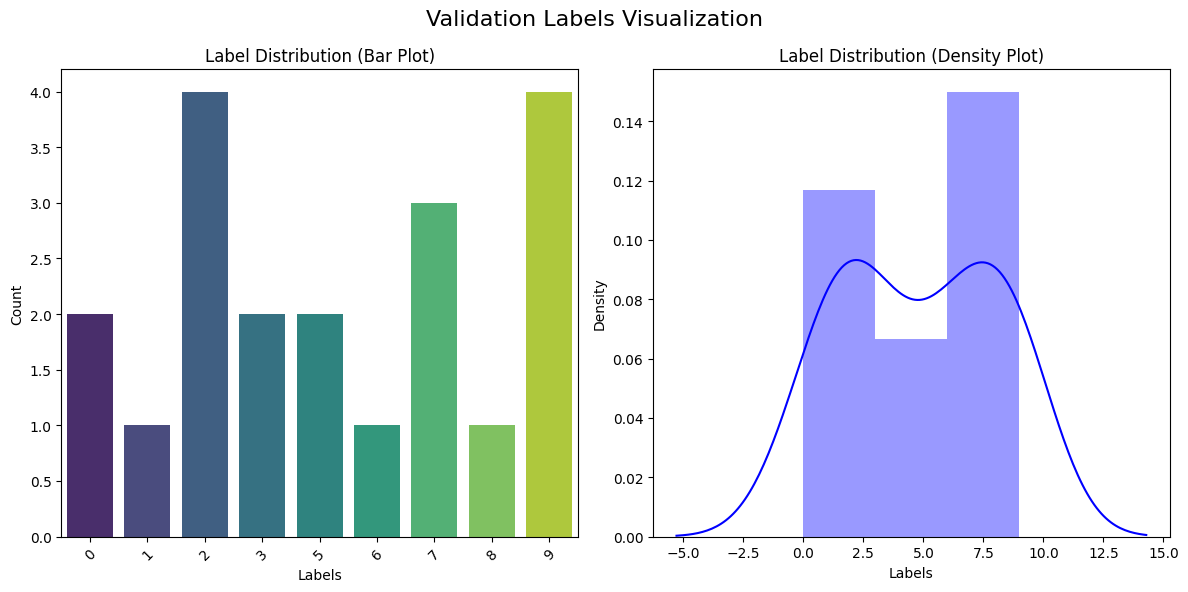

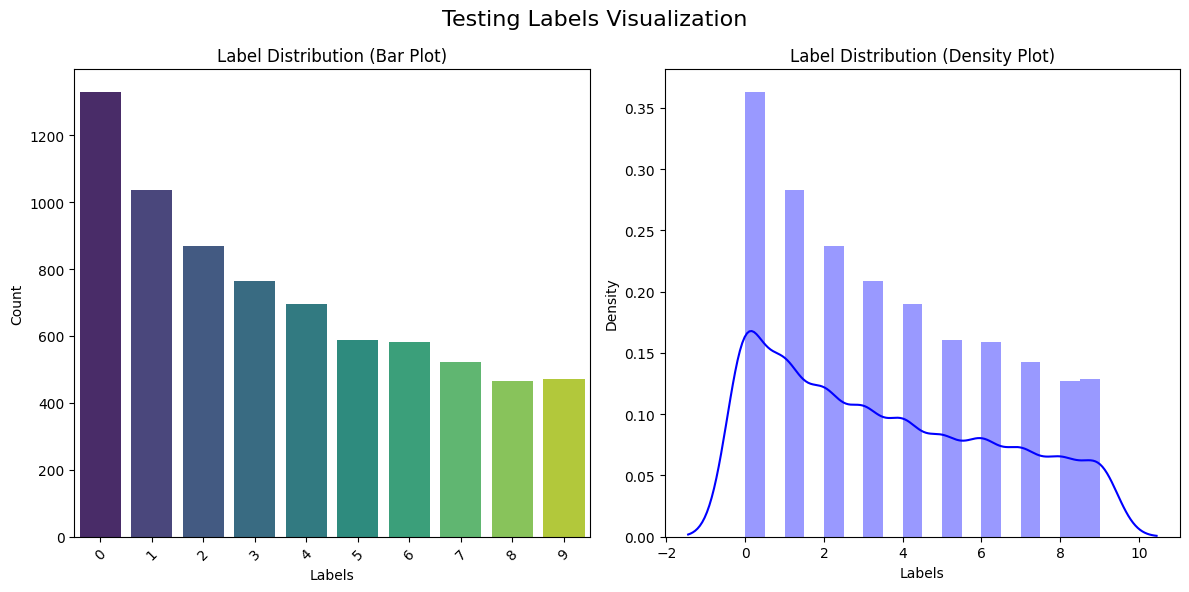

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def plot_distribution(y,title):
    
    # Create a figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Create the bar plot on the first subplot
    sns.countplot(x=y, palette='viridis', ax=axes[0])
    axes[0].set_xlabel('Labels')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Label Distribution (Bar Plot)')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Create the distribution plot on the second subplot
    sns.distplot(y, kde=True, color='blue', ax=axes[1])
    axes[1].set_xlabel('Labels')
    axes[1].set_ylabel('Density')
    axes[1].set_title('Label Distribution (Density Plot)')
    
    # Add a title for the entire figure
    plt.suptitle(title+' Visualization', fontsize=16)
    
    plt.tight_layout()
    plt.show()

for i in [(y_train,'Training Labels'),(y_val,'Validation Labels'),(y_test,'Testing Labels')]:
    plot_distribution(i[0].flatten(),i[1])

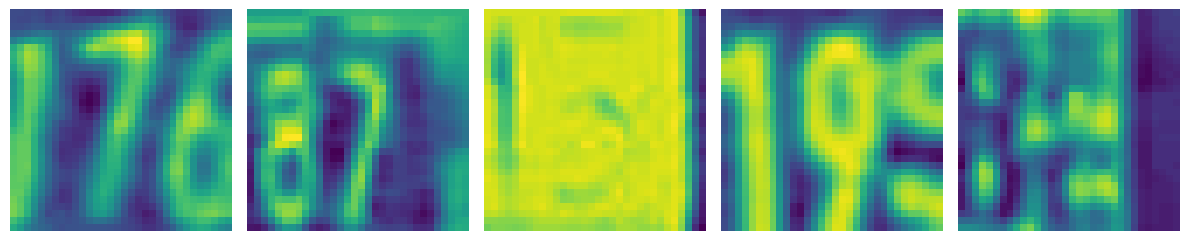

In [7]:
random_numbers = np.random.uniform(0, X_train.shape[0], 5)

fig, axes = plt.subplots(1, len(random_numbers), figsize=(12, 6))

for i, index in enumerate(random_numbers):
    ax = axes[i]
    ax.imshow(X_gray[int(index)])
    # print(y_train[int(index)])
    ax.axis('off')  # Turn off axis labels

plt.tight_layout()
plt.show()


### Preparing Dataset to train in Batches

In [8]:
import torch
from torch import nn
from torch.utils.data import Dataset

class CustomDataset(Dataset):

    def __init__(self,X,y):
        self.data = X
        self.labels = y

    def __len__(self):
        return len(self.labels)

    def __getitem__(self,idx):
        data_sample = self.data[idx]  # Get a single data sample
        label = self.labels[idx]
        return data_sample, label


training_dataset = CustomDataset(X_train,y_train)
val_dataset = CustomDataset(X_val,y_val)
test_dataset = CustomDataset(X_test,y_test)

In [9]:
from torch.utils.data import DataLoader

batch_size = 128
train_dataloader = DataLoader(training_dataset,batch_size=batch_size,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=batch_size,shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=batch_size)

In [10]:
# Testing cell

next(iter(train_dataloader))[0].shape

torch.Size([128, 32, 32])

### Creating model class 

In [13]:
#creating model class

class Model(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape,activation_fn):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_units),
            activation_fn,
            nn.Linear(hidden_units, output_shape),
            activation_fn
        )
    
    def forward(self, X):
        return self.layers(X)


In [14]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [15]:
import matplotlib.pyplot as plt

def plot_loss_graph(loss, epochs,loss_type):
    x_axis = range(epochs)
    plt.figure(figsize=(8, 6))
    print(x_axis)
    plt.plot(x_axis, loss, label=loss_type, color='b', marker='o', linestyle='-')
    plt.title(loss_type)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
# plot_loss_graph(train_loss_list, num_epochs)


In [22]:
## defining function abstraction for training and testing functionalities
from tqdm.auto import tqdm

def training_step(model,dataloader,X,y,train_loss_list,loss_fn,optimizer):

    torch.manual_seed(42)
    train_loss = 0
    
    for batch,(X,y) in enumerate(dataloader):
        
        y_pred = model(X)
        
        y  = torch.squeeze(y)
#         y = y.long()
        loss = loss_fn(y_pred, y)  
        train_loss += loss
        train_acc = accuracy_fn(y_true=y,y_pred=y_pred.argmax(dim=1))
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()

        if batch%520 == 0:
            print(f"Looked at {batch*len(X)}/{len(dataloader)} samples.")

    train_loss /=len(train_dataloader)

    print(f"Training loss : {train_loss} | Train acc: {train_acc:.4f}| ")
    train_loss_list.append(train_loss.item())

def testing_step(model,dataloader,X,y,test_loss_list,accuracy_list,loss_fn):
    torch.manual_seed(42)
    test_loss = 0
    test_acc = 0
    model.eval()
    
    with torch.inference_mode():
        for X, y in dataloader:
            test_pred = model(X)
            y = torch.squeeze(y)
            test_loss+=loss_fn(test_pred,y)
            test_acc += accuracy_fn(y_true=y,y_pred = test_pred.argmax(dim=1))

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
    print(f"Test loss : {test_loss:.4f} | Test acc : {test_acc:.4f}")
    test_loss_list.append(test_loss.item())
    accuracy_list.append(test_acc)


### 1. ReLU

In [112]:
torch.manual_seed(42)

model = Model(1024,256,10,nn.ReLU()).double()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model.parameters(),
                            lr=0.1)

In [113]:
torch.manual_seed(42)

EPOCHS = 15

train_loss = 0

train_loss_list = []
test_loss_list_train = []
accuracy_list_train = []

val_loss_list = []
test_loss_list_val = []
accuracy_list_val = []

# training and testing loop
for epoch in tqdm(range(EPOCHS)):
    training_step(model,train_dataloader,X_train,y_train,train_loss_list)
    testing_step(model,test_dataloader,X_test,y_test,test_loss_list_train,accuracy_list_train)

#training and validation loop
EPOCHS = 6
for epoch in tqdm(range(EPOCHS)):
    training_step(model,val_dataloader,X_val,y_val,val_loss_list)
    testing_step(model,test_dataloader,X_test,y_test,test_loss_list_val,accuracy_list_val)

  0%|                                                    | 0/15 [00:00<?, ?it/s]

Looked at 0/515 samples.


  7%|██▉                                         | 1/15 [00:00<00:13,  1.06it/s]

Training loss : 2.203502867955722 | Train acc: 26.8908| 
Test loss : 2.0748 | Test acc : 28.3728
Looked at 0/515 samples.


 13%|█████▊                                      | 2/15 [00:01<00:12,  1.02it/s]

Training loss : 1.9645360052733412 | Train acc: 40.3361| 
Test loss : 1.8403 | Test acc : 41.5607
Looked at 0/515 samples.


 20%|████████▊                                   | 3/15 [00:02<00:11,  1.01it/s]

Training loss : 1.792841721470179 | Train acc: 43.6975| 
Test loss : 1.7327 | Test acc : 43.8236
Looked at 0/515 samples.


 27%|███████████▋                                | 4/15 [00:03<00:11,  1.01s/it]

Training loss : 1.6521921098364658 | Train acc: 57.1429| 
Test loss : 1.5441 | Test acc : 52.2459
Looked at 0/515 samples.


 33%|██████████████▋                             | 5/15 [00:04<00:09,  1.01it/s]

Training loss : 1.5550620527228975 | Train acc: 54.6218| 
Test loss : 1.4804 | Test acc : 54.6237
Looked at 0/515 samples.


 40%|█████████████████▌                          | 6/15 [00:05<00:08,  1.00it/s]

Training loss : 1.4934901770131093 | Train acc: 58.8235| 
Test loss : 1.4030 | Test acc : 56.3551
Looked at 0/515 samples.


 47%|████████████████████▌                       | 7/15 [00:06<00:07,  1.00it/s]

Training loss : 1.4483907841421193 | Train acc: 62.1849| 
Test loss : 1.3643 | Test acc : 56.8705
Looked at 0/515 samples.


 53%|███████████████████████▍                    | 8/15 [00:07<00:06,  1.00it/s]

Training loss : 1.401615268547944 | Train acc: 61.3445| 
Test loss : 1.3337 | Test acc : 57.3860
Looked at 0/515 samples.


 60%|██████████████████████████▍                 | 9/15 [00:09<00:06,  1.02s/it]

Training loss : 1.369901899397841 | Train acc: 62.1849| 
Test loss : 1.3172 | Test acc : 57.7829
Looked at 0/515 samples.


 67%|████████████████████████████▋              | 10/15 [00:09<00:05,  1.01s/it]

Training loss : 1.3407668073224488 | Train acc: 61.3445| 
Test loss : 1.3074 | Test acc : 58.0864
Looked at 0/515 samples.


 73%|███████████████████████████████▌           | 11/15 [00:10<00:03,  1.00it/s]

Training loss : 1.3124880655525464 | Train acc: 61.3445| 
Test loss : 1.2949 | Test acc : 58.1268
Looked at 0/515 samples.


 80%|██████████████████████████████████▍        | 12/15 [00:11<00:03,  1.00s/it]

Training loss : 1.2964027170456938 | Train acc: 62.1849| 
Test loss : 1.2776 | Test acc : 58.7329
Looked at 0/515 samples.


 87%|█████████████████████████████████████▎     | 13/15 [00:12<00:02,  1.00s/it]

Training loss : 1.2749480080689841 | Train acc: 63.0252| 
Test loss : 1.2720 | Test acc : 58.9215
Looked at 0/515 samples.


 93%|████████████████████████████████████████▏  | 14/15 [00:13<00:00,  1.00it/s]

Training loss : 1.2613847068862334 | Train acc: 62.1849| 
Test loss : 1.2474 | Test acc : 59.1065
Looked at 0/515 samples.


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.00it/s]


Training loss : 1.2449145490219766 | Train acc: 61.3445| 
Test loss : 1.2288 | Test acc : 60.0126


  0%|                                                     | 0/6 [00:00<?, ?it/s]

Looked at 0/1 samples.
Training loss : 0.002941379445410087 | Train acc: 40.0000| 
Test loss : 1.3609 | Test acc : 54.1056
Looked at 0/1 samples.
Training loss : 0.002403571828521664 | Train acc: 50.0000| 


 33%|███████████████                              | 2/6 [00:00<00:00, 12.49it/s]

Test loss : 1.4333 | Test acc : 52.8628
Looked at 0/1 samples.
Training loss : 0.002288073202042584 | Train acc: 60.0000| 


 67%|██████████████████████████████               | 4/6 [00:00<00:00, 13.59it/s]

Test loss : 1.3467 | Test acc : 54.7656
Looked at 0/1 samples.
Training loss : 0.0022705209797644096 | Train acc: 60.0000| 
Test loss : 1.5163 | Test acc : 50.3269
Looked at 0/1 samples.
Training loss : 0.0022016319413512304 | Train acc: 60.0000| 
Test loss : 1.3838 | Test acc : 53.4591
Looked at 0/1 samples.
Training loss : 0.0022055625336054765 | Train acc: 60.0000| 


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 13.74it/s]

Test loss : 1.4859 | Test acc : 50.5424


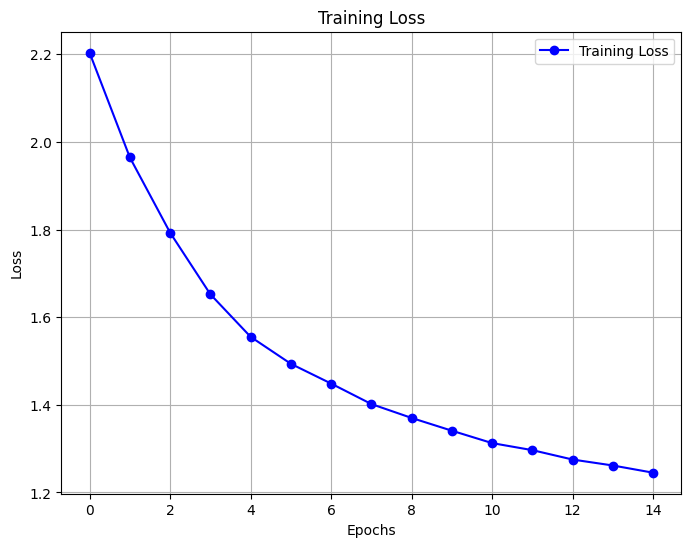

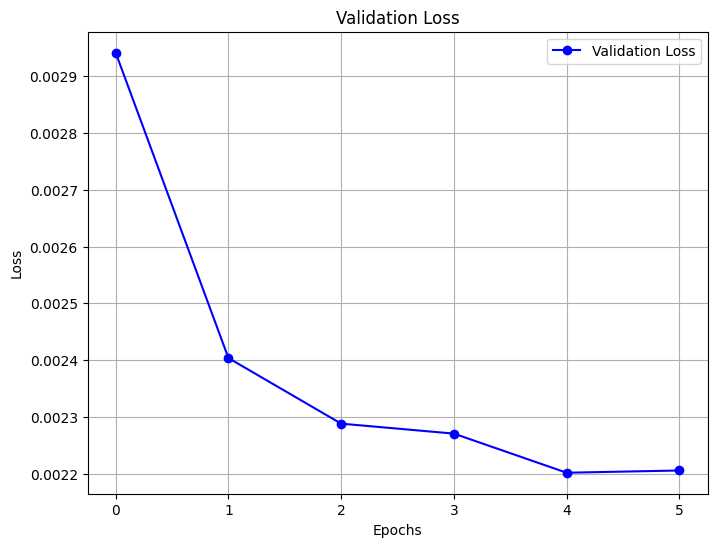

In [114]:
plot_loss_graph(train_loss_list,15,"Training Loss")

plot_loss_graph(val_loss_list,6,"Validation Loss")

In [77]:
# Code to find misclassified images

map = {1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[],10:[]}  # Assuming you have 10 classes

model.eval()

test_loss = 0
with torch.inference_mode():
    for X, y in test_dataloader:
        test_pred = model(X)
        y = torch.squeeze(y)
        test_loss += loss_fn(test_pred, y)
        
        # Get the predicted labels and true labels
        predicted_labels = test_pred.argmax(dim=1)
        
        # Find the misclassified samples
        misclassified_indices = (predicted_labels != y).nonzero().squeeze()
        for index in misclassified_indices:
            true_label = y[index].item()
            true_label+=1
            predicted_label = predicted_labels[index].item() + 1
            if(len(map[true_label])<3):
                map[true_label].append((X[index], predicted_label))

# for i in range(1,11):
#     print(len(map[i]))

Class 1 Misclassified Examples:


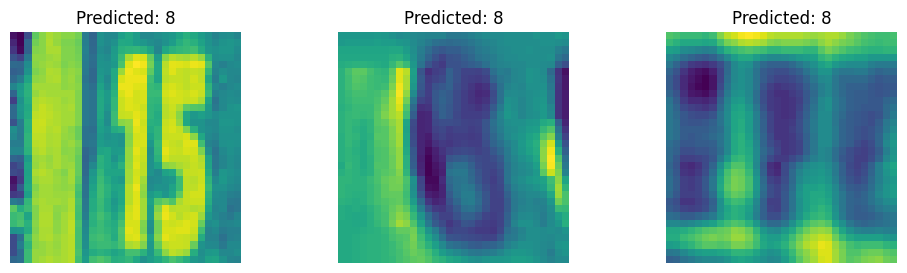

Class 2 Misclassified Examples:


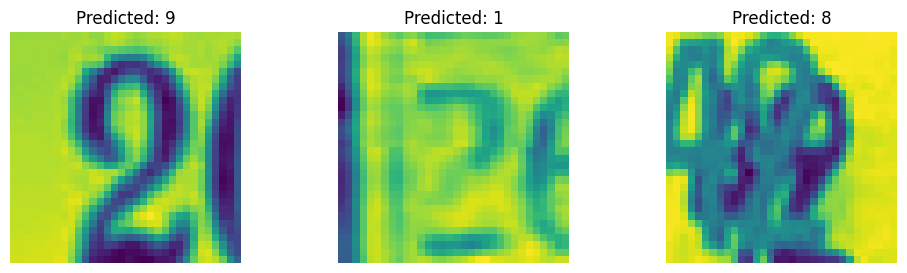

Class 3 Misclassified Examples:


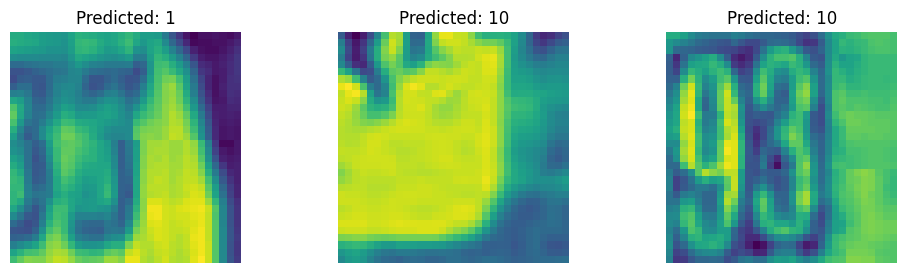

Class 4 Misclassified Examples:


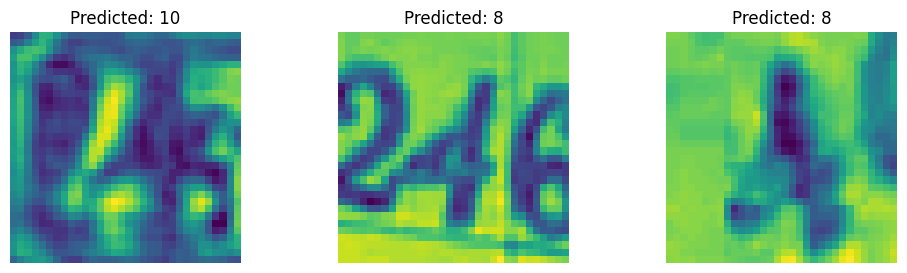

Class 5 Misclassified Examples:


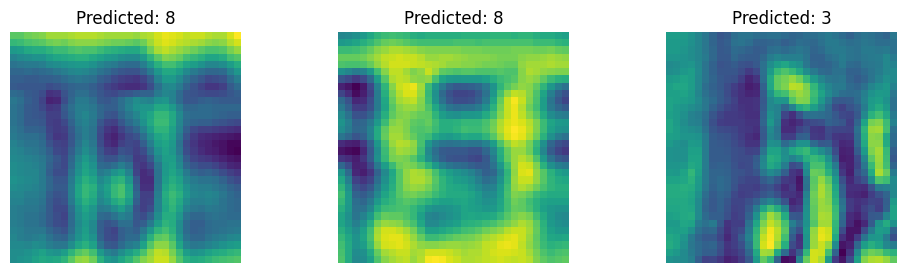

Class 6 Misclassified Examples:


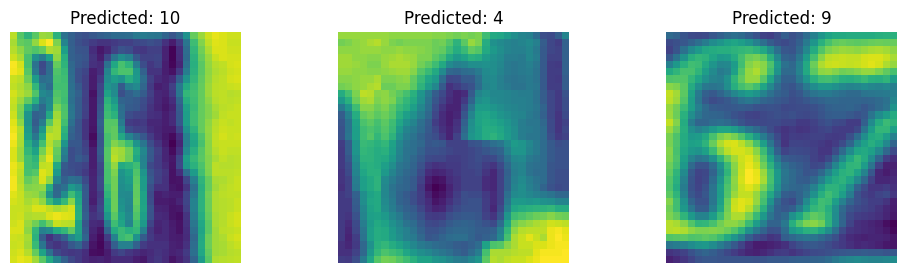

Class 7 Misclassified Examples:


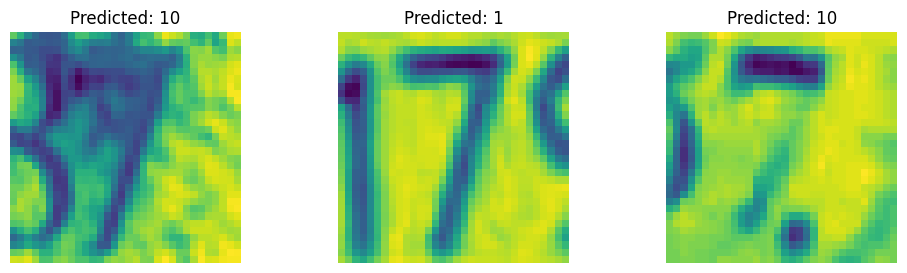

Class 8 Misclassified Examples:


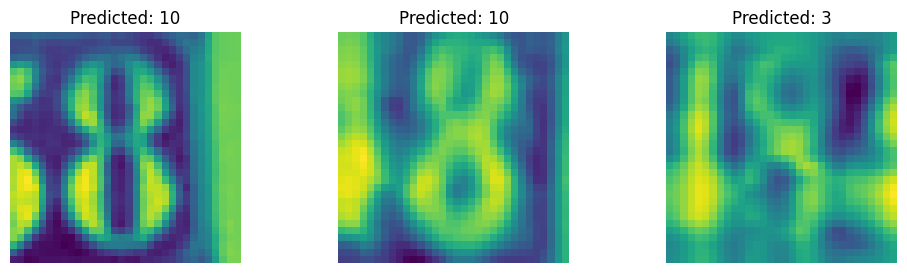

Class 9 Misclassified Examples:


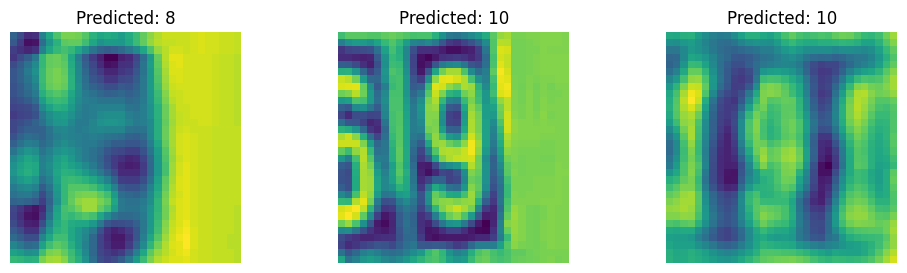

Class 10 Misclassified Examples:


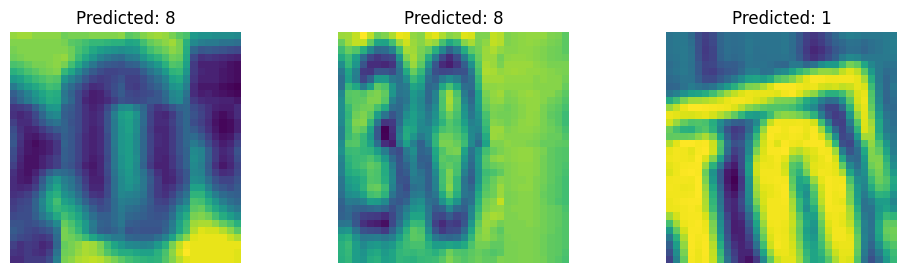

In [78]:
# Visualizing misclassified samples

for true_label, misclassified_samples in map.items():
    print(f"Class {true_label} Misclassified Examples:")
    fig, axes = plt.subplots(1, len(misclassified_samples), figsize=(12, 3))
    for i, (flattened_image, predicted_label) in enumerate(misclassified_samples):
        reshaped_image = flattened_image.reshape(32,32)
        axes[i].imshow(reshaped_image)
        axes[i].set_title(f"Predicted: {predicted_label}")
        axes[i].axis('off')

    plt.show()


## tanh

In [33]:
torch.manual_seed(42)

model = Model(1024,256,10,nn.Tanh()).double()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model.parameters(),
                            lr=0.1)

In [36]:
torch.manual_seed(42)

EPOCHS = 15

train_loss = 0

train_loss_list = []
test_loss_list_train = []
accuracy_list_train = []

val_loss_list = []
test_loss_list_val = []
accuracy_list_val = []

# training and testing loop
for epoch in tqdm(range(EPOCHS)):
    training_step(model,train_dataloader,X_train,y_train,train_loss_list,loss_fn,optimizer)
    testing_step(model,test_dataloader,X_test,y_test,test_loss_list_train,accuracy_list_train,loss_fn)

#training and validation loop
EPOCHS = 6
for epoch in tqdm(range(EPOCHS)):
    training_step(model,val_dataloader,X_val,y_val,val_loss_list,loss_fn,optimizer)
    testing_step(model,test_dataloader,X_test,y_test,test_loss_list_val,accuracy_list_val,loss_fn)

  0%|                                                    | 0/15 [00:00<?, ?it/s]

Looked at 0/515 samples.


  7%|██▉                                         | 1/15 [00:00<00:13,  1.04it/s]

Training loss : 2.210991178467815 | Train acc: 20.1681| 
Test loss : 2.1856 | Test acc : 19.7414
Looked at 0/515 samples.


 13%|█████▊                                      | 2/15 [00:01<00:12,  1.08it/s]

Training loss : 2.144633632148242 | Train acc: 19.3277| 
Test loss : 2.1248 | Test acc : 20.6376
Looked at 0/515 samples.


 20%|████████▊                                   | 3/15 [00:02<00:11,  1.09it/s]

Training loss : 2.087542312406674 | Train acc: 16.8067| 
Test loss : 2.0778 | Test acc : 19.2906
Looked at 0/515 samples.


 27%|███████████▋                                | 4/15 [00:03<00:10,  1.09it/s]

Training loss : 2.0387032789436703 | Train acc: 18.4874| 
Test loss : 2.0356 | Test acc : 20.5469
Looked at 0/515 samples.


 33%|██████████████▋                             | 5/15 [00:04<00:09,  1.05it/s]

Training loss : 1.9923210166536747 | Train acc: 19.3277| 
Test loss : 1.9953 | Test acc : 21.9684
Looked at 0/515 samples.


 40%|█████████████████▌                          | 6/15 [00:05<00:08,  1.05it/s]

Training loss : 1.9528440008672077 | Train acc: 20.1681| 
Test loss : 1.9578 | Test acc : 23.5713
Looked at 0/515 samples.


 47%|████████████████████▌                       | 7/15 [00:06<00:07,  1.03it/s]

Training loss : 1.9198201881288082 | Train acc: 20.1681| 
Test loss : 1.9278 | Test acc : 25.3224
Looked at 0/515 samples.


 53%|███████████████████████▍                    | 8/15 [00:07<00:06,  1.02it/s]

Training loss : 1.8908364303255325 | Train acc: 22.6891| 
Test loss : 1.8965 | Test acc : 28.7069
Looked at 0/515 samples.


 60%|██████████████████████████▍                 | 9/15 [00:08<00:05,  1.00it/s]

Training loss : 1.852173997327003 | Train acc: 36.1345| 
Test loss : 1.8104 | Test acc : 44.3023
Looked at 0/515 samples.


 67%|████████████████████████████▋              | 10/15 [00:09<00:04,  1.01it/s]

Training loss : 1.7875262050515182 | Train acc: 39.4958| 
Test loss : 1.7703 | Test acc : 44.7234
Looked at 0/515 samples.


 73%|███████████████████████████████▌           | 11/15 [00:10<00:03,  1.01it/s]

Training loss : 1.7375391121761548 | Train acc: 40.3361| 
Test loss : 1.7319 | Test acc : 46.5724
Looked at 0/515 samples.


 80%|██████████████████████████████████▍        | 12/15 [00:11<00:02,  1.02it/s]

Training loss : 1.7029273357205892 | Train acc: 44.5378| 
Test loss : 1.7040 | Test acc : 47.6401
Looked at 0/515 samples.


 87%|█████████████████████████████████████▎     | 13/15 [00:12<00:01,  1.02it/s]

Training loss : 1.6765435399302606 | Train acc: 47.0588| 
Test loss : 1.6787 | Test acc : 48.8389
Looked at 0/515 samples.


 93%|████████████████████████████████████████▏  | 14/15 [00:13<00:00,  1.02it/s]

Training loss : 1.6556281173708087 | Train acc: 47.8992| 
Test loss : 1.6579 | Test acc : 50.2227
Looked at 0/515 samples.


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.03it/s]


Training loss : 1.6381556469015706 | Train acc: 46.2185| 
Test loss : 1.6400 | Test acc : 51.4350


  0%|                                                     | 0/6 [00:00<?, ?it/s]

Looked at 0/1 samples.
Training loss : 0.0038677933960621015 | Train acc: 25.0000| 
Test loss : 1.7258 | Test acc : 43.8003
Looked at 0/1 samples.
Training loss : 0.0037938379946017777 | Train acc: 30.0000| 


 33%|███████████████                              | 2/6 [00:00<00:00, 10.90it/s]

Test loss : 1.6975 | Test acc : 45.7543
Looked at 0/1 samples.
Training loss : 0.0036846480687913736 | Train acc: 35.0000| 


 67%|██████████████████████████████               | 4/6 [00:00<00:00, 11.01it/s]

Test loss : 1.7083 | Test acc : 47.4713
Looked at 0/1 samples.
Training loss : 0.0034108886129585758 | Train acc: 40.0000| 
Test loss : 1.6938 | Test acc : 48.7581
Looked at 0/1 samples.
Training loss : 0.0033502755660829078 | Train acc: 40.0000| 
Test loss : 1.7140 | Test acc : 46.6604
Looked at 0/1 samples.
Training loss : 0.00333223998538467 | Train acc: 50.0000| 


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.99it/s]

Test loss : 1.7332 | Test acc : 47.3069


range(0, 15)


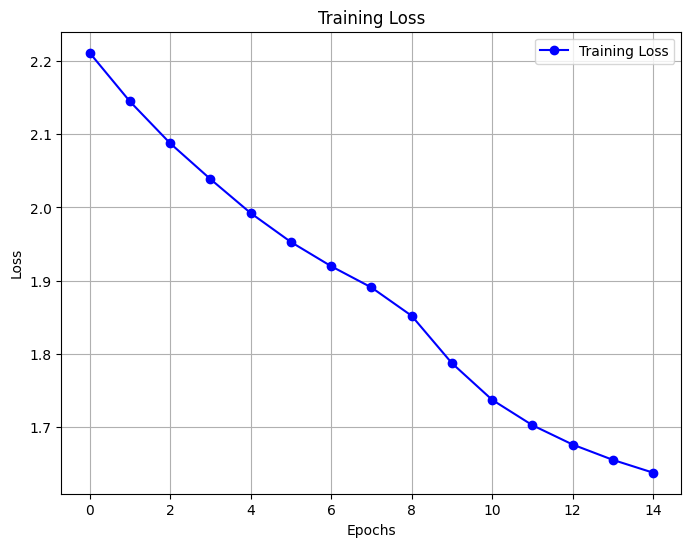

range(0, 6)


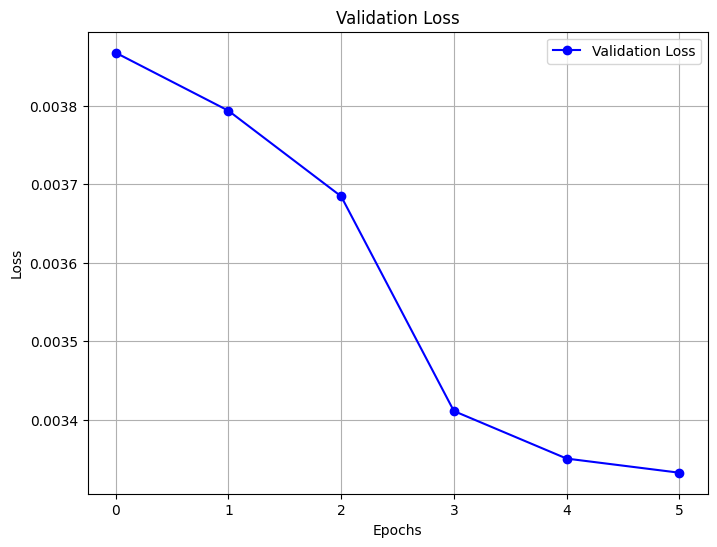

In [37]:
plot_loss_graph(train_loss_list,15,"Training Loss")

plot_loss_graph(val_loss_list,6,"Validation Loss")

In [53]:
# Code to find misclassified images

map = {1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[],10:[]}  # Assuming you have 10 classes

model.eval()

test_loss = 0
with torch.inference_mode():
    for X, y in test_dataloader:
        test_pred = model(X)
        y = torch.squeeze(y)
        test_loss += loss_fn(test_pred, y)
        
        # Get the predicted labels and true labels
        predicted_labels = test_pred.argmax(dim=1)
        
        # Find the misclassified samples
        misclassified_indices = (predicted_labels != y).nonzero().squeeze()
        for index in misclassified_indices:
            true_label = y[index].item()
            true_label+=1
            predicted_label = predicted_labels[index].item() + 1
            if(len(map[true_label])<3):
                map[true_label].append((X[index], predicted_label))

# for i in range(1,11):
#     print(len(map[i]))

Class 1 Misclassified Examples:


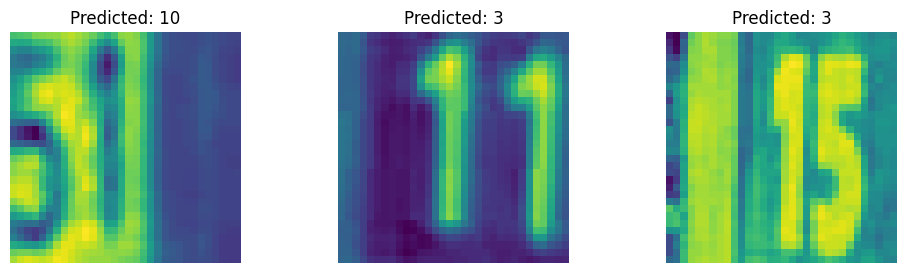

Class 2 Misclassified Examples:


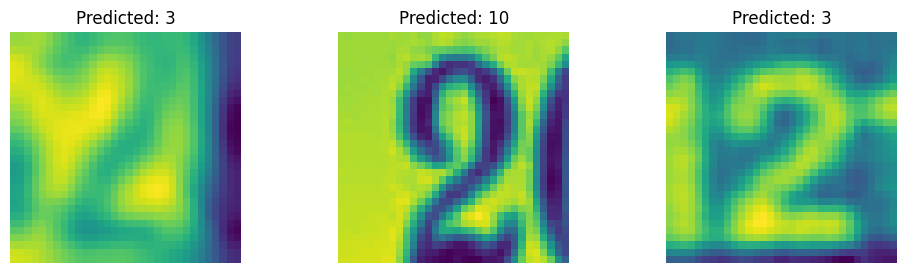

Class 3 Misclassified Examples:


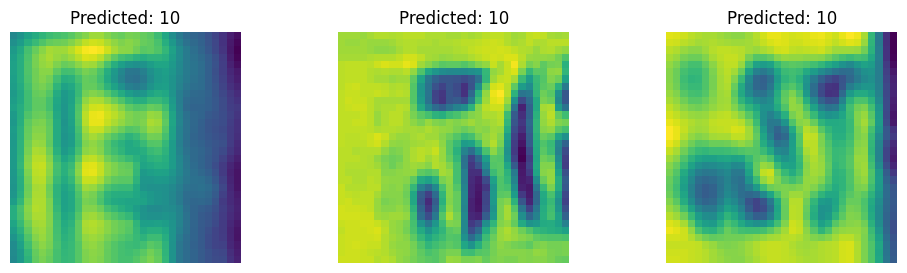

Class 4 Misclassified Examples:


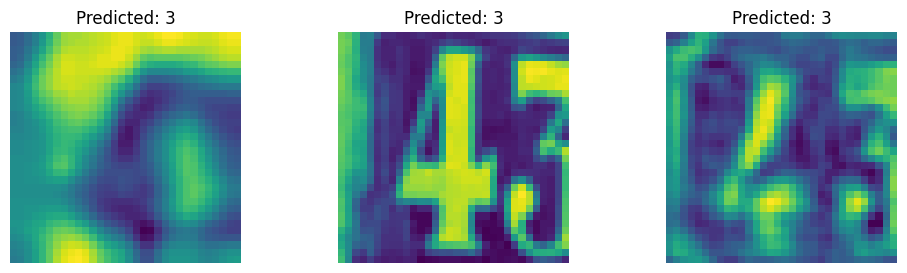

Class 5 Misclassified Examples:


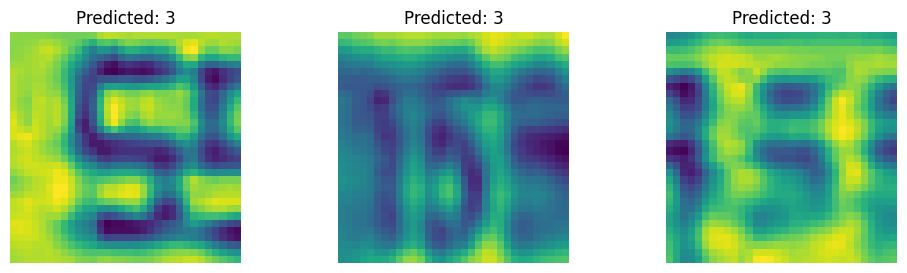

Class 6 Misclassified Examples:


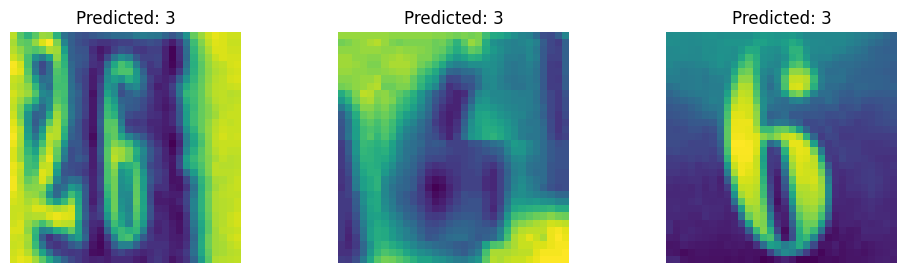

Class 7 Misclassified Examples:


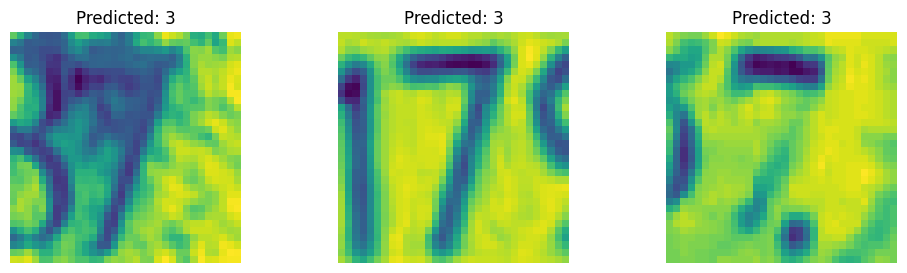

Class 8 Misclassified Examples:


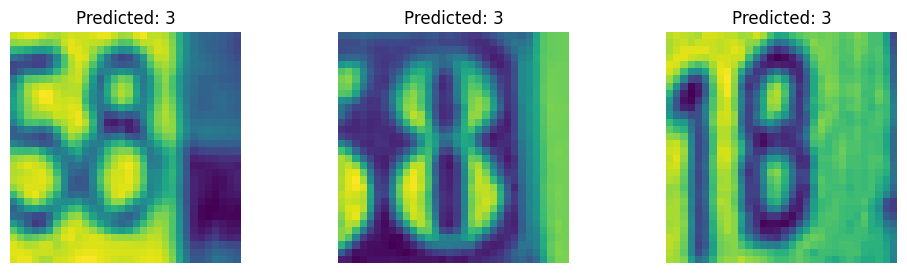

Class 9 Misclassified Examples:


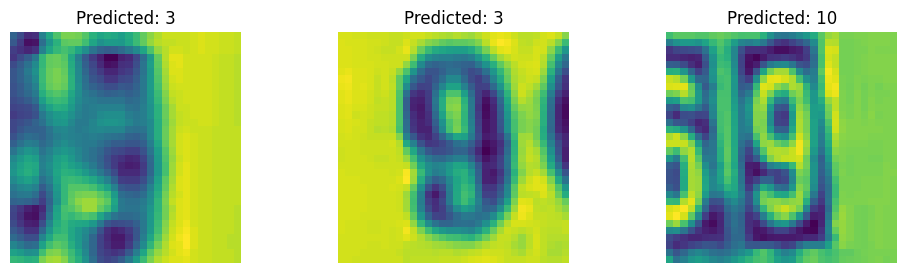

Class 10 Misclassified Examples:


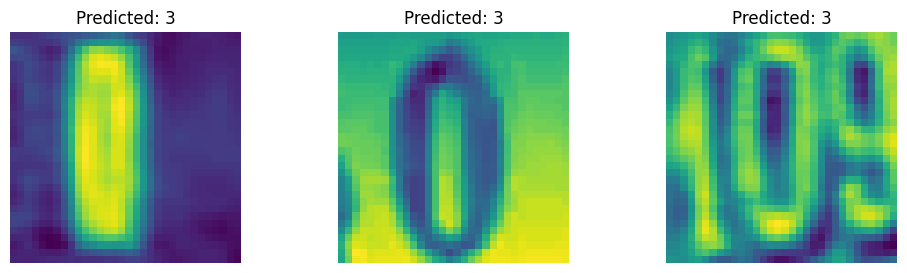

In [54]:
# Visualizing misclassified samples

for true_label, misclassified_samples in map.items():
    print(f"Class {true_label} Misclassified Examples:")
    fig, axes = plt.subplots(1, len(misclassified_samples), figsize=(12, 3))
    for i, (flattened_image, predicted_label) in enumerate(misclassified_samples):
        reshaped_image = flattened_image.reshape(32,32)
        axes[i].imshow(reshaped_image)
        axes[i].set_title(f"Predicted: {predicted_label}")
        axes[i].axis('off')

    plt.show()


## Sigmoid

In [43]:
torch.manual_seed(42)

model = Model(1024,256,10,nn.Sigmoid()).double()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model.parameters(),
                            lr=1)

In [44]:
torch.manual_seed(42)

EPOCHS = 20

train_loss = 0

train_loss_list = []
test_loss_list_train = []
accuracy_list_train = []

val_loss_list = []
test_loss_list_val = []
accuracy_list_val = []

# training and testing loop
for epoch in tqdm(range(EPOCHS)):
    training_step(model,train_dataloader,X_train,y_train,train_loss_list,loss_fn,optimizer)
    testing_step(model,test_dataloader,X_test,y_test,test_loss_list_train,accuracy_list_train,loss_fn)

#training and validation loop
EPOCHS = 6
for epoch in tqdm(range(EPOCHS)):
    training_step(model,val_dataloader,X_val,y_val,val_loss_list,loss_fn,optimizer)
    testing_step(model,test_dataloader,X_test,y_test,test_loss_list_val,accuracy_list_val,loss_fn)

  0%|                                                    | 0/20 [00:00<?, ?it/s]

Looked at 0/515 samples.


  5%|██▏                                         | 1/20 [00:01<00:19,  1.02s/it]

Training loss : 2.2386089671147857 | Train acc: 18.4874| 
Test loss : 2.2444 | Test acc : 18.1483
Looked at 0/515 samples.


 10%|████▍                                       | 2/20 [00:01<00:17,  1.02it/s]

Training loss : 2.2365331948717326 | Train acc: 18.4874| 
Test loss : 2.2430 | Test acc : 18.1483
Looked at 0/515 samples.


 15%|██████▌                                     | 3/20 [00:02<00:16,  1.02it/s]

Training loss : 2.234996609615035 | Train acc: 18.4874| 
Test loss : 2.2407 | Test acc : 18.1483
Looked at 0/515 samples.


 20%|████████▊                                   | 4/20 [00:03<00:15,  1.01it/s]

Training loss : 2.2318363937159442 | Train acc: 18.4874| 
Test loss : 2.2357 | Test acc : 18.1483
Looked at 0/515 samples.


 25%|███████████                                 | 5/20 [00:05<00:15,  1.01s/it]

Training loss : 2.221189031167917 | Train acc: 18.4874| 
Test loss : 2.2195 | Test acc : 18.2022
Looked at 0/515 samples.


 30%|█████████████▏                              | 6/20 [00:06<00:14,  1.01s/it]

Training loss : 2.198808542412454 | Train acc: 19.3277| 
Test loss : 2.1981 | Test acc : 18.9637
Looked at 0/515 samples.


 35%|███████████████▍                            | 7/20 [00:06<00:12,  1.01it/s]

Training loss : 2.178873849738918 | Train acc: 19.3277| 
Test loss : 2.1746 | Test acc : 18.9700
Looked at 0/515 samples.


 40%|█████████████████▌                          | 8/20 [00:07<00:11,  1.02it/s]

Training loss : 2.1604737933292615 | Train acc: 23.5294| 
Test loss : 2.1550 | Test acc : 23.8874
Looked at 0/515 samples.


 45%|███████████████████▊                        | 9/20 [00:08<00:10,  1.03it/s]

Training loss : 2.1436342524809646 | Train acc: 25.2101| 
Test loss : 2.1361 | Test acc : 26.8310
Looked at 0/515 samples.


 50%|█████████████████████▌                     | 10/20 [00:09<00:09,  1.04it/s]

Training loss : 2.1282019105035705 | Train acc: 26.0504| 
Test loss : 2.1204 | Test acc : 28.2992
Looked at 0/515 samples.


 55%|███████████████████████▋                   | 11/20 [00:10<00:08,  1.04it/s]

Training loss : 2.1132902528895072 | Train acc: 28.5714| 
Test loss : 2.1057 | Test acc : 29.1649
Looked at 0/515 samples.


 60%|█████████████████████████▊                 | 12/20 [00:11<00:07,  1.04it/s]

Training loss : 2.097245672578157 | Train acc: 27.7311| 
Test loss : 2.0901 | Test acc : 30.4849
Looked at 0/515 samples.


 65%|███████████████████████████▉               | 13/20 [00:12<00:06,  1.05it/s]

Training loss : 2.080963190601694 | Train acc: 27.7311| 
Test loss : 2.0746 | Test acc : 31.4817
Looked at 0/515 samples.


 70%|██████████████████████████████             | 14/20 [00:13<00:05,  1.03it/s]

Training loss : 2.0669838450726923 | Train acc: 28.5714| 
Test loss : 2.0623 | Test acc : 32.4246
Looked at 0/515 samples.


 75%|████████████████████████████████▎          | 15/20 [00:14<00:04,  1.04it/s]

Training loss : 2.0556209535605445 | Train acc: 30.2521| 
Test loss : 2.0532 | Test acc : 33.3270
Looked at 0/515 samples.


 80%|██████████████████████████████████▍        | 16/20 [00:15<00:03,  1.05it/s]

Training loss : 2.0461535566570825 | Train acc: 31.0924| 
Test loss : 2.0460 | Test acc : 34.2834
Looked at 0/515 samples.


 85%|████████████████████████████████████▌      | 17/20 [00:16<00:02,  1.06it/s]

Training loss : 2.038074869242009 | Train acc: 31.0924| 
Test loss : 2.0396 | Test acc : 35.1994
Looked at 0/515 samples.


 90%|██████████████████████████████████████▋    | 18/20 [00:17<00:01,  1.06it/s]

Training loss : 2.030993536770108 | Train acc: 35.2941| 
Test loss : 2.0333 | Test acc : 36.0848
Looked at 0/515 samples.


 95%|████████████████████████████████████████▊  | 19/20 [00:18<00:00,  1.06it/s]

Training loss : 2.0245842875333473 | Train acc: 36.9748| 
Test loss : 2.0273 | Test acc : 37.3312
Looked at 0/515 samples.


100%|███████████████████████████████████████████| 20/20 [00:19<00:00,  1.03it/s]


Training loss : 2.018571390845628 | Train acc: 36.1345| 
Test loss : 2.0213 | Test acc : 37.9508


 17%|███████▌                                     | 1/6 [00:00<00:00,  9.22it/s]

Looked at 0/1 samples.
Training loss : 0.004397871247405484 | Train acc: 15.0000| 
Test loss : 2.0369 | Test acc : 35.9698
Looked at 0/1 samples.
Training loss : 0.0043214677229503244 | Train acc: 20.0000| 
Test loss : 2.0375 | Test acc : 35.5487
Looked at 0/1 samples.
Training loss : 0.004265187424627734 | Train acc: 25.0000| 


 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 13.73it/s]

Test loss : 2.0398 | Test acc : 35.6564
Looked at 0/1 samples.
Training loss : 0.00423951446995742 | Train acc: 30.0000| 
Test loss : 2.0430 | Test acc : 34.4980
Looked at 0/1 samples.
Training loss : 0.00422020661681397 | Train acc: 30.0000| 
Test loss : 2.0483 | Test acc : 34.6731
Looked at 0/1 samples.
Training loss : 0.0042045805644282215 | Train acc: 30.0000| 


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 13.15it/s]

Test loss : 2.0519 | Test acc : 33.7572


range(0, 20)


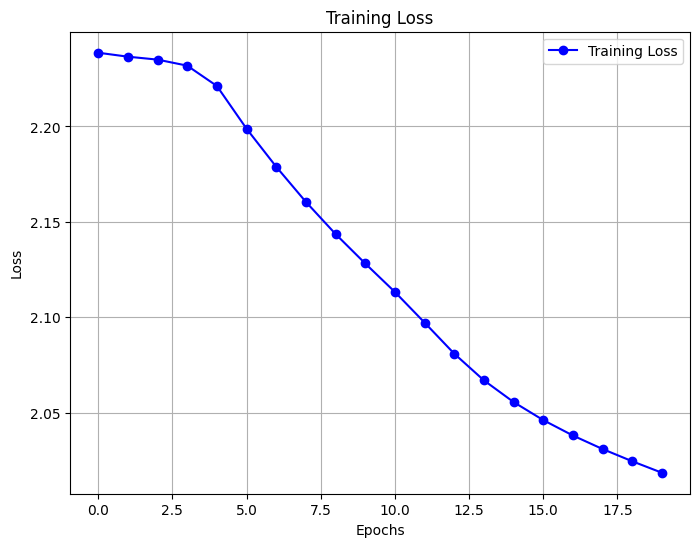

range(0, 6)


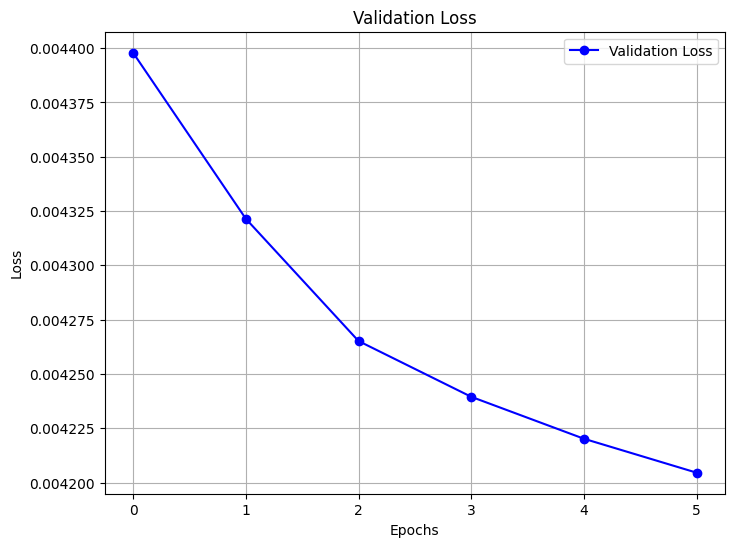

In [45]:
plot_loss_graph(train_loss_list,20,"Training Loss")

plot_loss_graph(val_loss_list,6,"Validation Loss")

In [46]:
# Code to find misclassified images

map = {1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[],10:[]}  # Assuming you have 10 classes

model.eval()

test_loss = 0
with torch.inference_mode():
    for X, y in test_dataloader:
        test_pred = model(X)
        y = torch.squeeze(y)
        test_loss += loss_fn(test_pred, y)
        
        # Get the predicted labels and true labels
        predicted_labels = test_pred.argmax(dim=1)
        
        # Find the misclassified samples
        misclassified_indices = (predicted_labels != y).nonzero().squeeze()
        for index in misclassified_indices:
            true_label = y[index].item()
            true_label+=1
            predicted_label = predicted_labels[index].item() + 1
            if(len(map[true_label])<3):
                map[true_label].append((X[index], predicted_label))

# for i in range(1,11):
#     print(len(map[i]))

Class 1 Misclassified Examples:


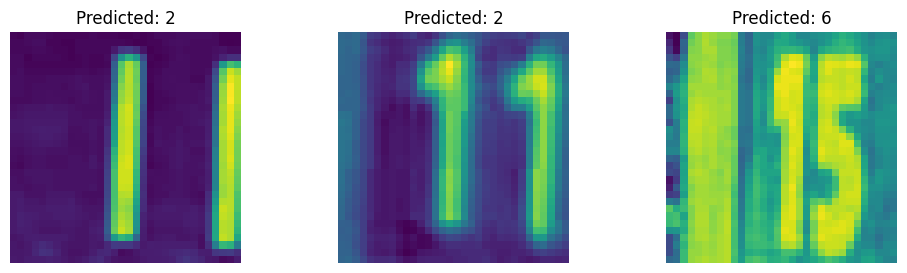

Class 2 Misclassified Examples:


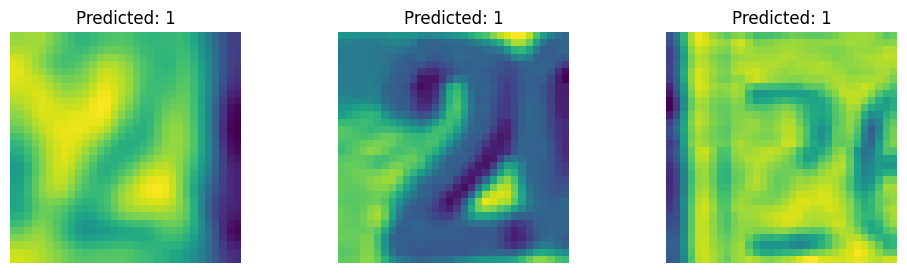

Class 3 Misclassified Examples:


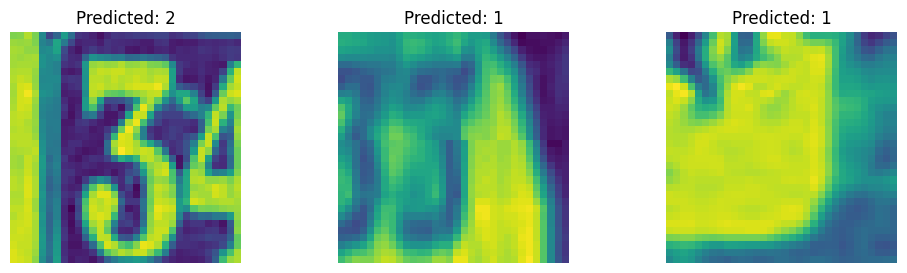

Class 4 Misclassified Examples:


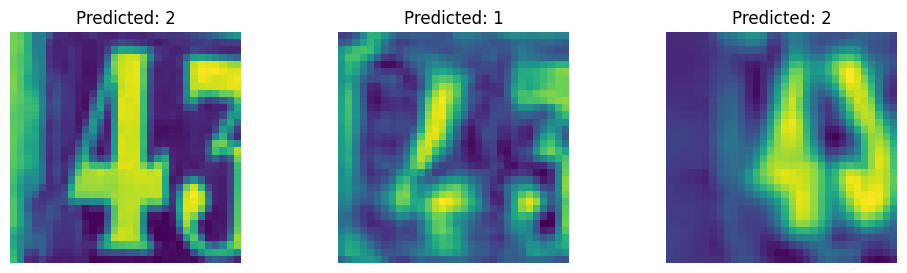

Class 5 Misclassified Examples:


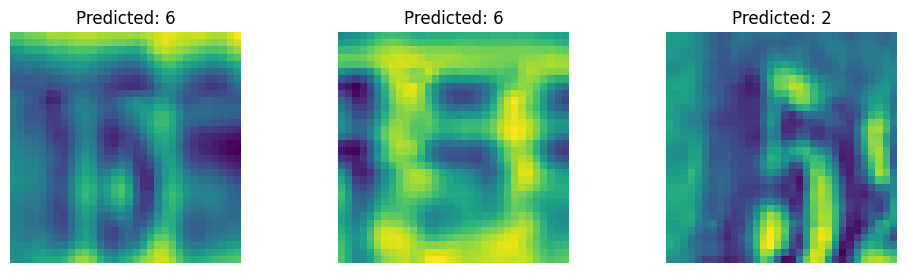

Class 6 Misclassified Examples:


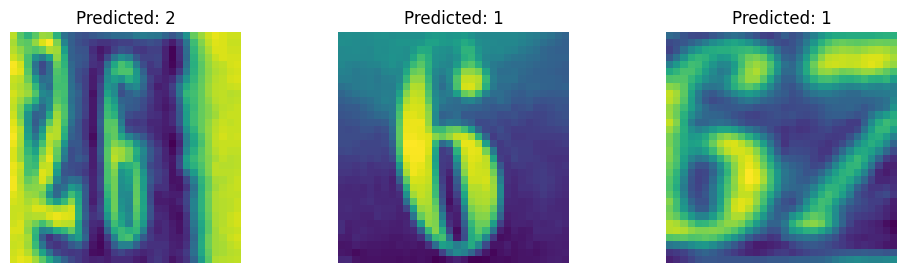

Class 7 Misclassified Examples:


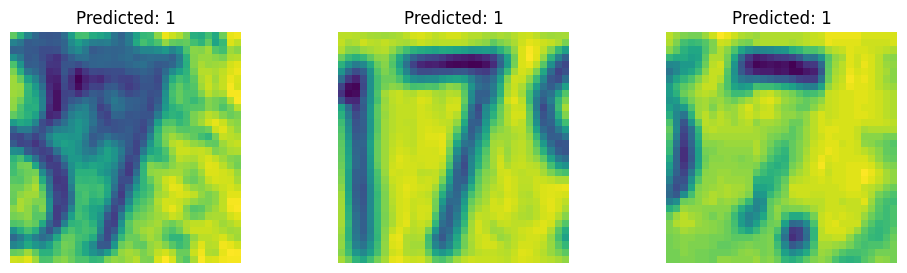

Class 8 Misclassified Examples:


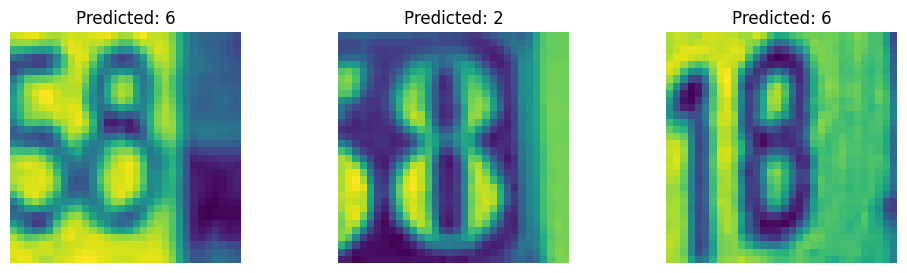

Class 9 Misclassified Examples:


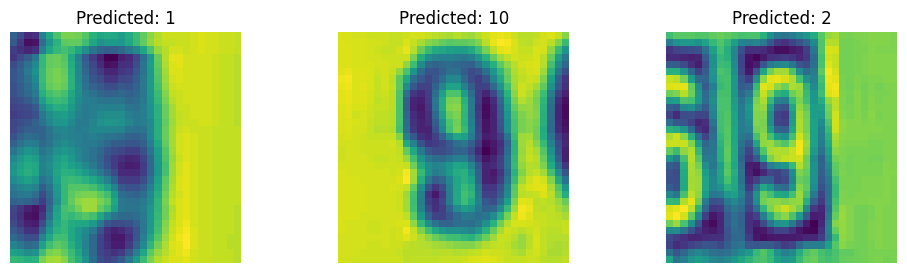

Class 10 Misclassified Examples:


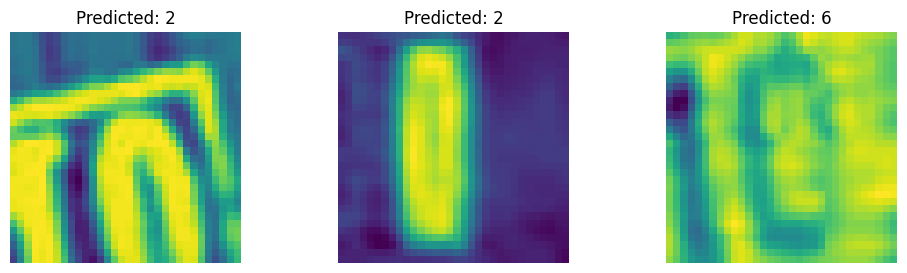

In [47]:
# Visualizing misclassified samples

for true_label, misclassified_samples in map.items():
    print(f"Class {true_label} Misclassified Examples:")
    fig, axes = plt.subplots(1, len(misclassified_samples), figsize=(12, 3))
    for i, (flattened_image, predicted_label) in enumerate(misclassified_samples):
        reshaped_image = flattened_image.reshape(32,32)
        axes[i].imshow(reshaped_image)
        axes[i].set_title(f"Predicted: {predicted_label}")
        axes[i].axis('off')

    plt.show()


## Linear

In [48]:
torch.manual_seed(42)

model = Model(1024,256,10,nn.Identity()).double()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model.parameters(),
                            lr=0.1)

In [49]:
torch.manual_seed(42)

EPOCHS = 20

train_loss = 0

train_loss_list = []
test_loss_list_train = []
accuracy_list_train = []

val_loss_list = []
test_loss_list_val = []
accuracy_list_val = []

# training and testing loop
for epoch in tqdm(range(EPOCHS)):
    training_step(model,train_dataloader,X_train,y_train,train_loss_list,loss_fn,optimizer)
    testing_step(model,test_dataloader,X_test,y_test,test_loss_list_train,accuracy_list_train,loss_fn)

#training and validation loop
EPOCHS = 6
for epoch in tqdm(range(EPOCHS)):
    training_step(model,val_dataloader,X_val,y_val,val_loss_list,loss_fn,optimizer)
    testing_step(model,test_dataloader,X_test,y_test,test_loss_list_val,accuracy_list_val,loss_fn)

  0%|                                                    | 0/20 [00:00<?, ?it/s]

Looked at 0/515 samples.


  5%|██▏                                         | 1/20 [00:01<00:20,  1.10s/it]

Training loss : 2.2411443757761758 | Train acc: 17.6471| 
Test loss : 2.2271 | Test acc : 20.1554
Looked at 0/515 samples.


 10%|████▍                                       | 2/20 [00:02<00:19,  1.07s/it]

Training loss : 2.2204663997131733 | Train acc: 17.6471| 
Test loss : 2.2138 | Test acc : 20.5765
Looked at 0/515 samples.


 15%|██████▌                                     | 3/20 [00:03<00:16,  1.01it/s]

Training loss : 2.2119139719668084 | Train acc: 19.3277| 
Test loss : 2.2068 | Test acc : 21.3111
Looked at 0/515 samples.


 20%|████████▊                                   | 4/20 [00:03<00:15,  1.06it/s]

Training loss : 2.2061861989611975 | Train acc: 19.3277| 
Test loss : 2.2027 | Test acc : 21.8499
Looked at 0/515 samples.


 25%|███████████                                 | 5/20 [00:04<00:13,  1.09it/s]

Training loss : 2.2019643089726917 | Train acc: 19.3277| 
Test loss : 2.2002 | Test acc : 22.1695
Looked at 0/515 samples.


 30%|█████████████▏                              | 6/20 [00:05<00:12,  1.10it/s]

Training loss : 2.19867837975227 | Train acc: 20.1681| 
Test loss : 2.1986 | Test acc : 22.2369
Looked at 0/515 samples.


 35%|███████████████▍                            | 7/20 [00:06<00:11,  1.10it/s]

Training loss : 2.1960163073220125 | Train acc: 21.8487| 
Test loss : 2.1975 | Test acc : 22.3581
Looked at 0/515 samples.


 40%|█████████████████▌                          | 8/20 [00:07<00:10,  1.11it/s]

Training loss : 2.1937953832908197 | Train acc: 22.6891| 
Test loss : 2.1967 | Test acc : 22.6006
Looked at 0/515 samples.


 45%|███████████████████▊                        | 9/20 [00:08<00:09,  1.12it/s]

Training loss : 2.191900318390911 | Train acc: 23.5294| 
Test loss : 2.1961 | Test acc : 22.6679
Looked at 0/515 samples.


 50%|█████████████████████▌                     | 10/20 [00:09<00:09,  1.10it/s]

Training loss : 2.1902543351353474 | Train acc: 23.5294| 
Test loss : 2.1956 | Test acc : 22.7622
Looked at 0/515 samples.


 55%|███████████████████████▋                   | 11/20 [00:10<00:08,  1.09it/s]

Training loss : 2.1888041576563664 | Train acc: 23.5294| 
Test loss : 2.1952 | Test acc : 22.8700
Looked at 0/515 samples.


 60%|█████████████████████████▊                 | 12/20 [00:11<00:07,  1.11it/s]

Training loss : 2.1875114950460337 | Train acc: 24.3697| 
Test loss : 2.1948 | Test acc : 22.9104
Looked at 0/515 samples.


 65%|███████████████████████████▉               | 13/20 [00:12<00:06,  1.09it/s]

Training loss : 2.186347979203913 | Train acc: 24.3697| 
Test loss : 2.1945 | Test acc : 22.8969
Looked at 0/515 samples.


 70%|██████████████████████████████             | 14/20 [00:13<00:05,  1.05it/s]

Training loss : 2.18529205408535 | Train acc: 25.2101| 
Test loss : 2.1942 | Test acc : 22.9777
Looked at 0/515 samples.


 75%|████████████████████████████████▎          | 15/20 [00:13<00:04,  1.08it/s]

Training loss : 2.184326993173041 | Train acc: 26.0504| 
Test loss : 2.1940 | Test acc : 22.9607
Looked at 0/515 samples.


 80%|██████████████████████████████████▍        | 16/20 [00:14<00:03,  1.10it/s]

Training loss : 2.1834395867669154 | Train acc: 26.0504| 
Test loss : 2.1938 | Test acc : 22.9876
Looked at 0/515 samples.


 85%|████████████████████████████████████▌      | 17/20 [00:15<00:02,  1.10it/s]

Training loss : 2.182619242363208 | Train acc: 26.0504| 
Test loss : 2.1936 | Test acc : 23.1124
Looked at 0/515 samples.


 90%|██████████████████████████████████████▋    | 18/20 [00:16<00:01,  1.09it/s]

Training loss : 2.1818573505987846 | Train acc: 25.2101| 
Test loss : 2.1934 | Test acc : 23.2202
Looked at 0/515 samples.


 95%|████████████████████████████████████████▊  | 19/20 [00:17<00:00,  1.09it/s]

Training loss : 2.1811468283259297 | Train acc: 25.2101| 
Test loss : 2.1933 | Test acc : 23.2337
Looked at 0/515 samples.


100%|███████████████████████████████████████████| 20/20 [00:18<00:00,  1.08it/s]


Training loss : 2.180481783336704 | Train acc: 25.2101| 
Test loss : 2.1931 | Test acc : 23.2606


  0%|                                                     | 0/6 [00:00<?, ?it/s]

Looked at 0/1 samples.
Training loss : 0.004673747978546107 | Train acc: 15.0000| 
Test loss : 2.2270 | Test acc : 22.6338
Looked at 0/1 samples.
Training loss : 0.004356008021092898 | Train acc: 25.0000| 


 33%|███████████████                              | 2/6 [00:00<00:00, 14.50it/s]

Test loss : 2.2982 | Test acc : 16.6128
Looked at 0/1 samples.
Training loss : 0.004158922665012639 | Train acc: 40.0000| 


 67%|██████████████████████████████               | 4/6 [00:00<00:00, 14.58it/s]

Test loss : 2.3690 | Test acc : 14.4944
Looked at 0/1 samples.
Training loss : 0.00402785727454664 | Train acc: 30.0000| 
Test loss : 2.4177 | Test acc : 14.1307
Looked at 0/1 samples.
Training loss : 0.003928046821486702 | Train acc: 30.0000| 


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 14.74it/s]

Test loss : 2.4499 | Test acc : 13.9422
Looked at 0/1 samples.
Training loss : 0.0038412930312100727 | Train acc: 30.0000| 
Test loss : 2.4718 | Test acc : 13.8883


range(0, 20)


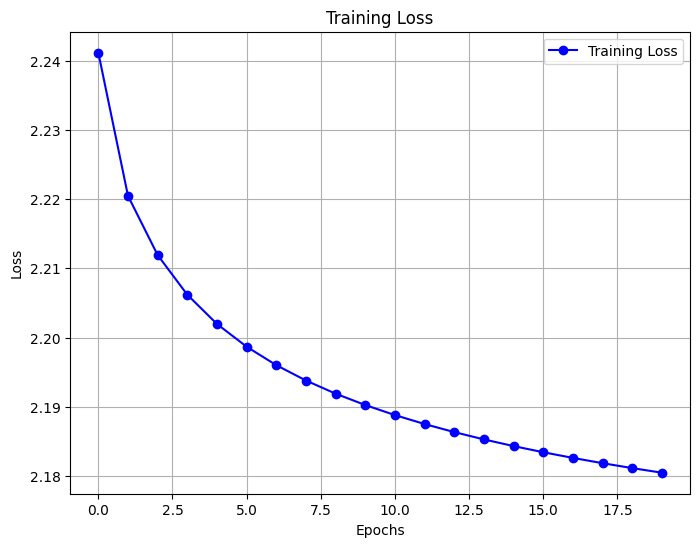

range(0, 6)


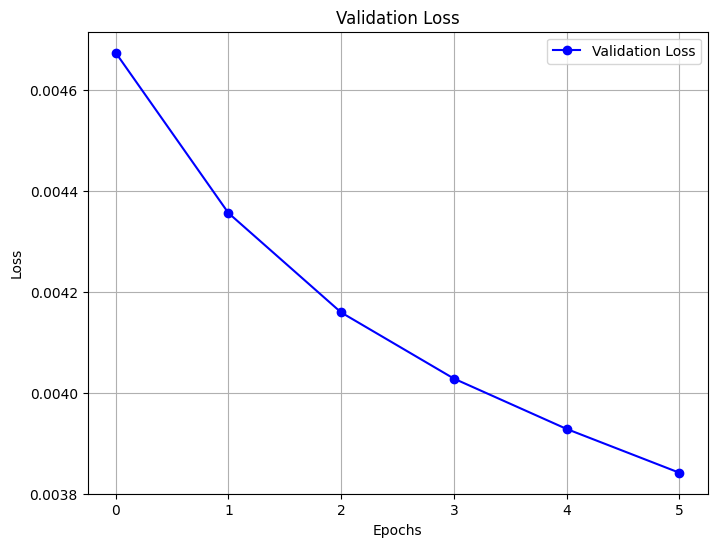

In [50]:
plot_loss_graph(train_loss_list,20,"Training Loss")

plot_loss_graph(val_loss_list,6,"Validation Loss")

In [51]:
# Code to find misclassified images

map = {1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[],10:[]}  # Assuming you have 10 classes

model.eval()

test_loss = 0
with torch.inference_mode():
    for X, y in test_dataloader:
        test_pred = model(X)
        y = torch.squeeze(y)
        test_loss += loss_fn(test_pred, y)
        
        # Get the predicted labels and true labels
        predicted_labels = test_pred.argmax(dim=1)
        
        # Find the misclassified samples
        misclassified_indices = (predicted_labels != y).nonzero().squeeze()
        for index in misclassified_indices:
            true_label = y[index].item()
            true_label+=1
            predicted_label = predicted_labels[index].item() + 1
            if(len(map[true_label])<3):
                map[true_label].append((X[index], predicted_label))

# for i in range(1,11):
#     print(len(map[i]))

Class 1 Misclassified Examples:


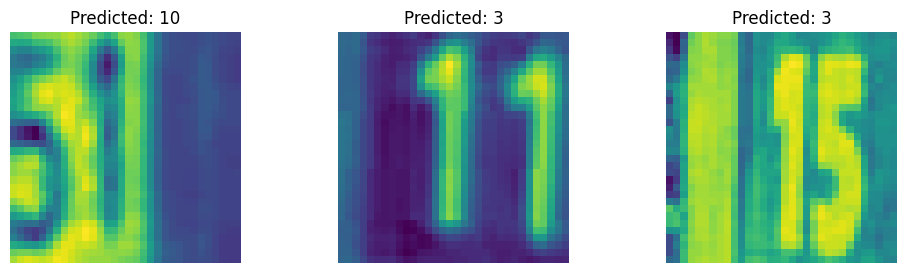

Class 2 Misclassified Examples:


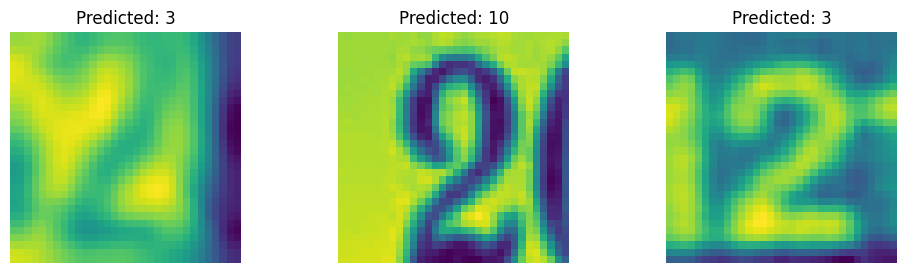

Class 3 Misclassified Examples:


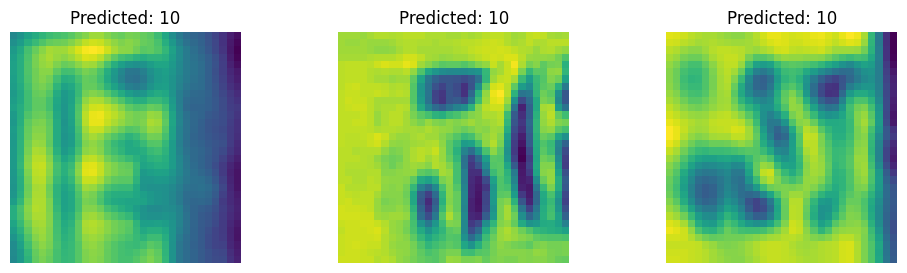

Class 4 Misclassified Examples:


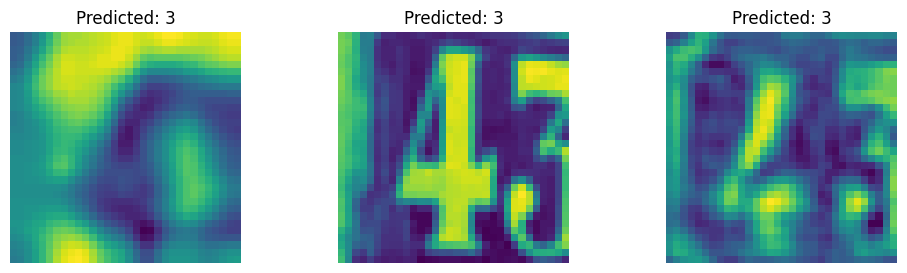

Class 5 Misclassified Examples:


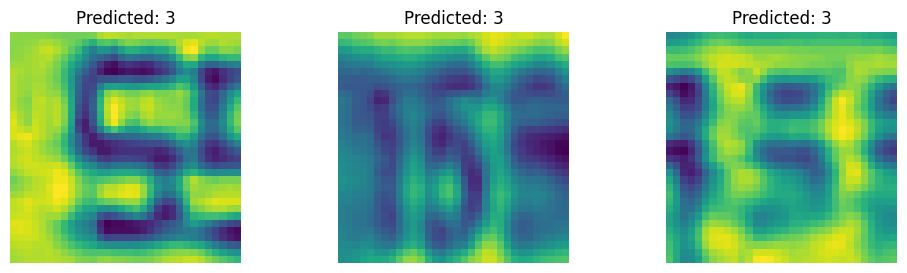

Class 6 Misclassified Examples:


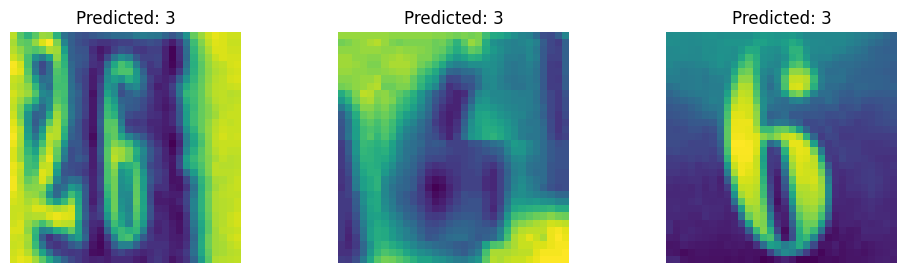

Class 7 Misclassified Examples:


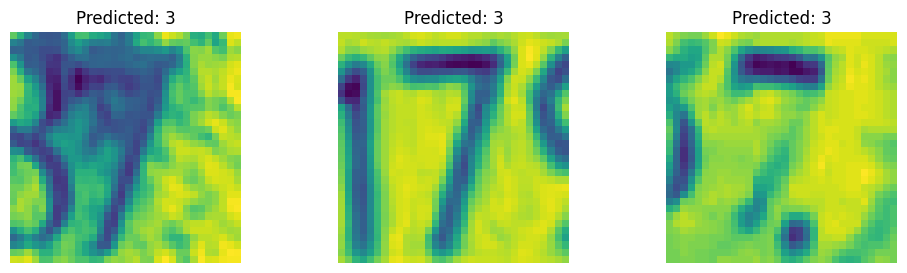

Class 8 Misclassified Examples:


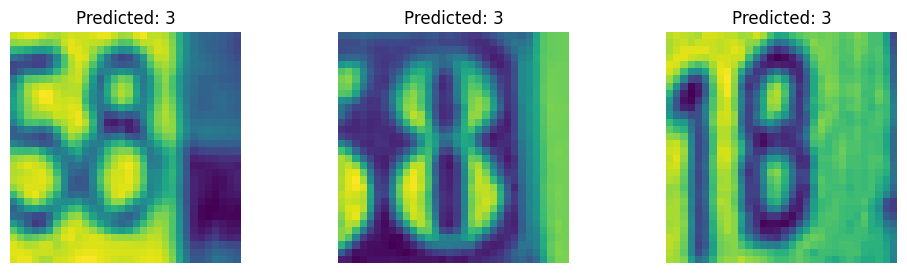

Class 9 Misclassified Examples:


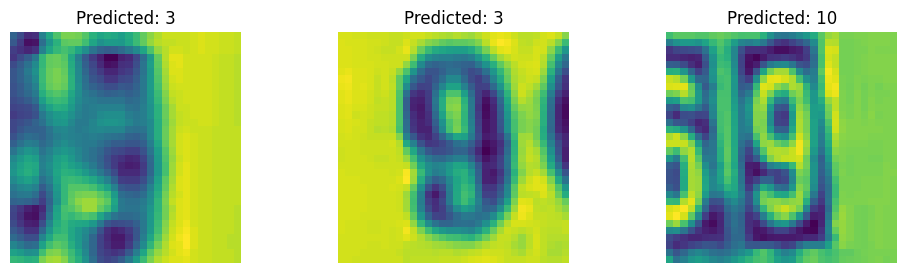

Class 10 Misclassified Examples:


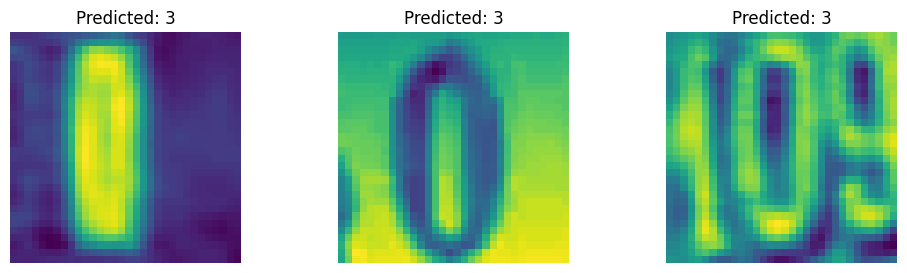

In [52]:
# Visualizing misclassified samples

for true_label, misclassified_samples in map.items():
    print(f"Class {true_label} Misclassified Examples:")
    fig, axes = plt.subplots(1, len(misclassified_samples), figsize=(12, 3))
    for i, (flattened_image, predicted_label) in enumerate(misclassified_samples):
        reshaped_image = flattened_image.reshape(32,32)
        axes[i].imshow(reshaped_image)
        axes[i].set_title(f"Predicted: {predicted_label}")
        axes[i].axis('off')

    plt.show()
